In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

PATH="/content/drive/MyDrive"


INPTAH = PATH + "/AI/INPUT"

OUTPTAH = PATH + "/AI/OUTPUT"

CKPATH = PATH + "/AI/checkpath"

imgurls = !ls -1 "{INPTAH}"


n = len(imgurls)

train_n = round(n * 0.80)

roundUrls = np.copy(imgurls)

np.random.seed(23)
np.random.shuffle(roundUrls)

tr_urls = roundUrls[:train_n]
ts_urls = roundUrls[train_n:n]

print(len(imgurls), len(tr_urls), len(ts_urls))

8 6 2


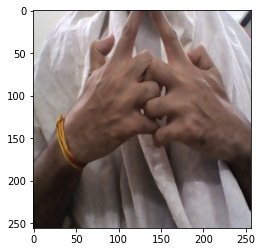

In [31]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

def resize(inimg, tgimg, heigth,width):
  inimg = tf.image.resize(inimg,[heigth,width])
  tgimg = tf.image.resize(tgimg,[heigth,width])

  return inimg,tgimg

def normalize(inimg, tgimg):
  inimg = (inimg/127.5) - 1 
  tgimg = (tgimg/127.5) - 1 

  return inimg,tgimg

@tf.function()
def random_jitter(inimg, tgimg):
  inimg, tgimg = resize(inimg, tgimg, 286, 286)
  stacked_image = tf.stack([inimg,tgimg], axis=0)
  cropped_img = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
  inimg, tgimg = cropped_img[0], cropped_img[1]
  
  if tf.random.uniform(()) > 0.5:
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)
  
  return inimg,tgimg

def load_image(filename, augment=True):
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPTAH + '/' + filename)), tf.float32)[..., :3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPTAH + '/' + filename)), tf.float32)[..., :3]

  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)

  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)
  
  inimg, tgimg = normalize(inimg, tgimg)

  return inimg, tgimg

def load_train_img(filename):
  return load_image(filename, True)

def load_test_img(filename):
  return load_image(filename, False)

plt.imshow(((load_train_img(roundUrls[0])[1])+ 1) / 2)


In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
test_dataset = test_dataset.map(load_test_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

In [32]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm=True):
  result = Sequential()

  initializer = tf.random_normal_initializer(0,0.02)
  #Capa covolucional
  result.add(Conv2D(filters,
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))

  #Capa covolucional
  if apply_batchnorm:
    result.add(BatchNormalization())

  #Capa covolucional
  result.add(LeakyReLU())

  return result;

downsample(64)

In [7]:
def upsample(filters, apply_dropout=False):
  result = Sequential()

  initializer = tf.random_normal_initializer(0,0.02)
  #Capa covolucional
  result.add(Conv2DTranspose(filters,
                             kernel_size=4,
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias=False))

  #Capa covolucional
  result.add(BatchNormalization())

  if apply_dropout:
    result.add(Dropout(0.5))

  #Capa covolucional
  result.add(ReLU())

  return result;

upsample(64)

In [33]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  down_stack = [
                downsample(64, apply_batchnorm=False),
                downsample(128),
                downsample(256),
                downsample(512),
                downsample(512),
                downsample(512),
                downsample(512),
                downsample(512),
  ]

  up_stack = [
                upsample(512, apply_dropout=True),
                upsample(512, apply_dropout=True),
                upsample(512, apply_dropout=True),
                upsample(512),
                upsample(256),
                upsample(128),
                upsample(64),
  ]

  initializer = tf.random_normal_initializer(0,0.02)
  last = Conv2DTranspose(filters=3,
                         kernel_size=4,
                         strides=2,
                         padding="same",
                         kernel_initializer=initializer,
                         activation="tanh")
  x = inputs
  s = []
  concat = Concatenate()
  for down in down_stack:
    x = down(x)
    s.append(x)

  s = reversed(s[:-1])

  for up,sk in zip(up_stack,s):
    x = up(x)
    x = concat([x,sk])
  last = last(x)
  return Model(inputs=inputs, outputs=last)

generator = Generator()

In [34]:
def Discriminator():
  ini = Input(shape=[None, None, 3], name="input_img")
  gen = Input(shape=[None, None, 3], name="gener_img")

  con = concatenate([ini, gen])

  initializer = tf.random_normal_initializer(0,0.02)

  down1 = downsample(64, apply_batchnorm=False)(con)
  down2 = downsample(128)(con)
  down3 = downsample(256)(con)
  down4 = downsample(512)(con)

  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding="same")(down4)
  return tf.keras.Model(inputs=[ini,gen], outputs=last)

discriminator = Discriminator()

In [24]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [13]:
LAMBDA = 100
def generator_loss(disc_generated_output,gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  l1_loss = tf.reduce_mean(tf.abs(target-gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [15]:
import os

generator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

AssertionError: ignored

In [18]:
def generate_images(model, test_input, tar,save_filename=False, display_imgs=True):
  prediction = model(test_input, training=True)

  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + '/AI/outputB/'+save_filename+'.jpg', prediction[0,...])
  
  plt.figure(figsize=(10,10))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [22]:
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    output_img = generator(input_image, training=True)

    output_gen_discr = discriminator([output_img, target], training=True)

    output_trg_disc = discriminator([target, input_image], training=True)

    discr_loss = discriminator_loss(output_trg_disc, output_gen_discr)

    gen_loss = generator_loss(output_gen_discr, output_img, target)

    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)

    discriminator_grads = disc_tape.gradient(discr_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

In [20]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):
    imgi = 0
    
    for input_image, target in dataset:
      print('epoch '+str(epoch)+' - train'+ str(imgi)+'/'+str(len(tr_urls)))
      imgi+=1
      train_step(input_image, target)
      clear_output(wait=True)
    imgi = 0
    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp, tar, str(imgi)+'_'+str(epoch), display_imgs=True)
      imgi+=1
    
    if (epoch+1)%50 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [36]:
train(train_dataset,100)

KeyboardInterrupt: ignored